In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



In [25]:
nx = 9
ny = 6

def calculate_camera_matrix_dist_coeffs():
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    fnames = glob.glob("camera_cal/calibration*.jpg")

    for fname in fnames:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    # use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
    ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)
    return (cameraMatrix, distortionCoeffs)

mtx, dist = calculate_camera_matrix_dist_coeffs()

def undistort(img, cameraMatrix=mtx, distortionCoeffs=dist):
    return cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)

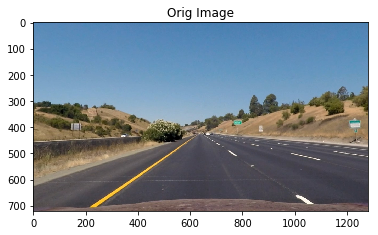

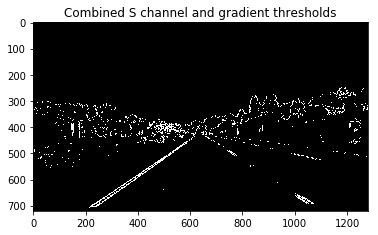

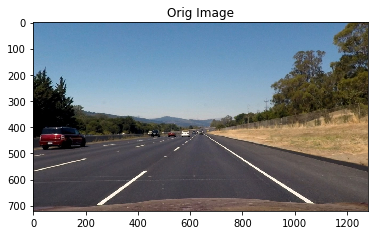

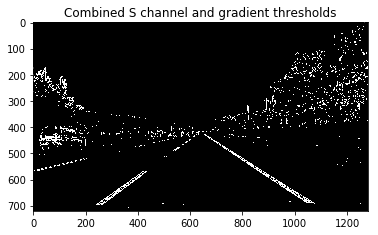

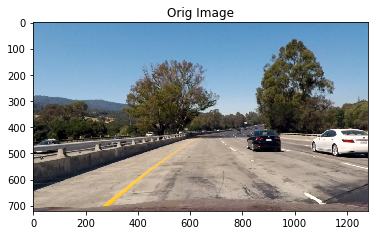

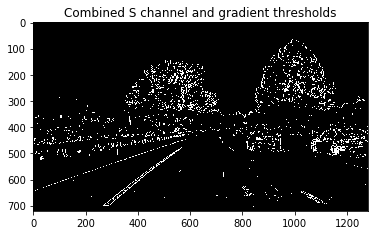

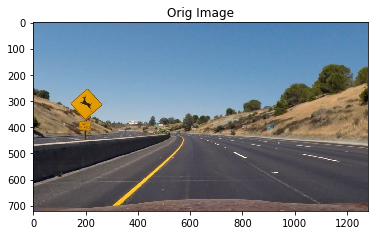

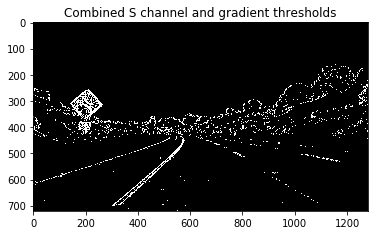

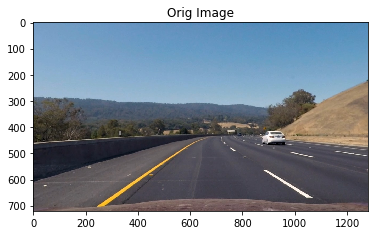

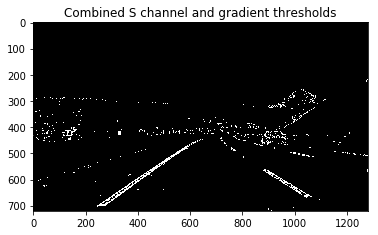

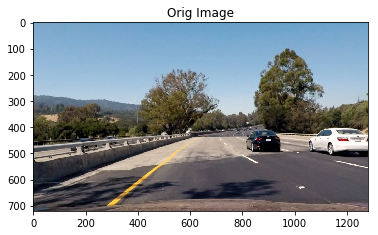

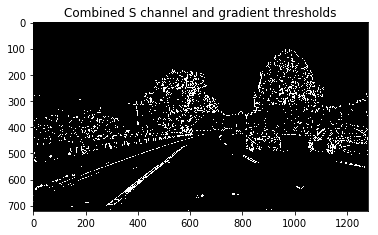

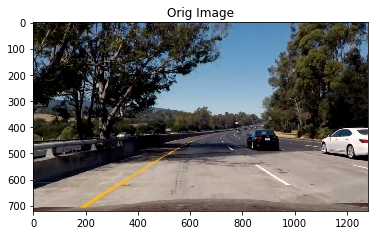

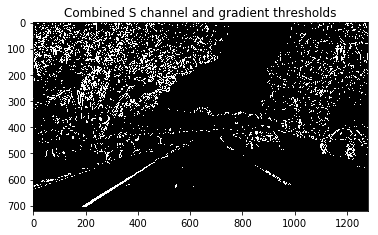

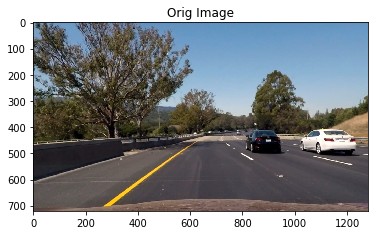

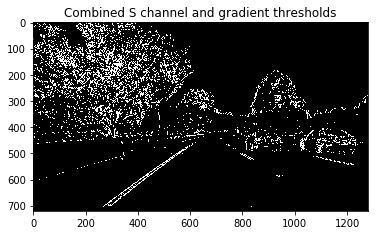

In [41]:


def threshold_binary(img):

    plt.imshow(img)
    plt.title('Orig Image')
    plt.show()
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
#     plt.imshow(s_channel)
#     plt.title('S Channel')
#     plt.show()

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
#     plt.imshow(scaled_sobel)
#     plt.title('Sobel X')
#     plt.show()
    

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 150
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
#     plt.imshow(sxbinary, cmap='gray')
#     plt.title('Threshold Gradient')
#     plt.show()
    

    # Threshold color channel
    s_thresh_min = 175
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    # Use inRange instead of multiple thresholds
    #retval, s_thresh1 = cv2.threshold(s_channel.astype('uint8'), 175, 255, cv2.THRESH_BINARY)    
    #retval, s_thresh2 = cv2.threshold(s_channel.astype('uint8'), 250, 255, cv2.THRESH_BINARY)    
    #s_thresh = np.zeros_like(s_binary)
    #s_thresh = s_thresh1 - s_thresh2
    #s_binary[(s_thresh >= s_thresh_min) & (s_thresh <= s_thresh_max)] = 1
    s_thresh = cv2.inRange(s_channel.astype('uint8'), 175, 250)

    s_binary[(s_thresh == 255)] = 1
    
#     plt.imshow(s_binary)
#     plt.title('Threshold Binary')
#     plt.show()
    

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    plt.title('Combined S channel and gradient thresholds')
    plt.imshow(combined_binary, cmap='gray')
    plt.show()

    return combined_binary


def process_img(img):
    undist = undistort(img)
    binary_img = threshold_binary(undist)

    return binary_img

def show_original_processed_img(img, processed):
    # Plot the original and undistorted images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(processed)
    ax2.set_title('Processed Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# Make a list of calibration images
fnames = glob.glob('test_images/*.jpg')

for fname in fnames:
    img = mpimg.imread(fname)
    processed = process_img(img)
#     show_original_processed_img(img, processed)

